In [44]:
import numpy as np
import sys
sys.path.append('./../../')
import mutator_classes as mc
from scipy import stats
from collections import OrderedDict
from copy import deepcopy
import stationary_distribution_aug as sd
from scipy import stats
from matplotlib import lines as Lines
from matplotlib import colors
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

get_phi = lambda s: s/(4*N*3e9*0.08*0.0005)

In [45]:
mpl.rcParams['figure.dpi'] = 400
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['legend.title_fontsize'] = 10
sns.set_style('whitegrid')
purple = [0.7,0.1,0.7]
coral = [.973, .414, .575]
teal = [0,0.55,0.55]
charcoal = [0.3,0.3,0.3]

sns.set

<function seaborn.rcmod.set(*args, **kwargs)>

In [46]:
p = mc.Parameters(**OrderedDict([('h',1),('s',0.0005),('N',20000),('loci',3e9*0.08),('mutation_rate',1),('M',1),('phi',1),('mutator_mutation_rate',1.25e-08)]))

In [10]:
get_phi = lambda s: s/(2*p.N*p.h*p.s*p.loci*2)
s_values = np.logspace(1,3,41)
sd_results = {}
for index,s in enumerate(s_values):
    if index % 10 == 9: print(index+1)
    p.phi = get_phi(s)
    sel = (p.h*p.s*p.loci*2*p.phi)
    sd_results[deepcopy(p)] = sd.get_SD(p)

10
20
30
40


In [47]:
from collections import defaultdict as ddict
    
var_qvalues = []
var_within_values = []
mean_qvalues = []
secondmoment_qvalues = []
x_values = []
prob_zero_mutators = []
m_max = 31
phi = []

for p,statdist in sd_results.items():
    
    # calculate various moments and statistics about allele frequency
    x_values.append(4*p.N*p.loci*p.h*p.s*p.phi)
    phi.append(p.phi)
        
    mean_freq = sum(pp*q for pp,q in statdist.items())
    mean_qvalues.append(mean_freq)
    
    second_moment_freq = sum(pp**2*q for pp,q in statdist.items())
    var_qvalues.append(second_moment_freq-mean_freq**2)
    secondmoment_qvalues.append(second_moment_freq)
    
    var_within_values.append((p.phi)**2*sum(2*pp*(1-pp)*q for pp,q in statdist.items()))
    
    prob_zero_mutators.append(sum(((1-q)**(4*nn)+q**(4*nn))*p for q,p in statdist.items()))
    
# make sure the arrays are sorted
x_ord = np.argsort(x_values)
x_values = np.array(x_values)[x_ord]
mean_qvalues = np.array(mean_qvalues)[x_ord]
prob_zero_mutators = np.array(prob_zero_mutators)[x_ord]
var_qvalues = np.array(var_qvalues)[x_ord]
secondmoment_qvalues = np.array(secondmoment_qvalues)[x_ord]

In [70]:
def detection_figure(ax,s_values = s_values,m = 1,sd_values = sd_results,loci = 3e9,u0=1.25e-8):
    
    plt.sca(ax)
    color = mpl.cm.get_cmap('viridis')(0)
    phi_values = get_phi(s_values)

    # get the expectation and variance of the number of DNM if m mutators
    # we assume # of DNM is poisson distributed per proband
    expectedDNM = []
    for p,statdist in sd_values.items():
        mean_increase = 2*p.phi*sum([p*q for p,q in statdist.items()])
        expectedDNM.append(p.phi*loci*m + 2*loci*(u0-mean_increase*m))
    expectedDNM = np.array(expectedDNM)
    
    plt.plot(s_values,expectedDNM,color = mpl.cm.get_cmap('viridis')(0))
    plt.fill_between(s_values,
                     expectedDNM+expectedDNM**(0.5),
                     expectedDNM-expectedDNM**(0.5),
                     color = color[:3],
                     edgecolor = color,
                     alpha = 0.25)
    
    # plot distribution of DNM if assuming a constant mutation rate
    expectedCON = np.zeros(len(s_values))+(2*loci*u0)
    plt.plot(s_values,
             expectedCON,
             color = 'k')  
    plt.fill_between(s_values,
                     expectedCON-expectedCON**(0.5),
                     expectedCON+expectedCON**(0.5),
                     alpha = 0.25,
                     color = 'k',
                     edgecolor = [0,0,0,1],
                     lw = 0.5)
    
    # do some plotting stuff
    plt.text(x = 200,y = 175, s = '1 Mutator',color = color,size = 10,rotation = 52)
    plt.text(x = 200,y = 87, s = 'No Mutators',color = 'k',size = 10)

    plt.xlabel('Scaled selection parameter ' + r'$(4NhsL\phi)$')
    plt.xscale('log')
    
    plt.ylabel('Number of de novo mutations')
    plt.yscale('linear')
    plt.ylim([0,425])
    
    p1 = ax.fill([],[],[],color='k',ls='-',alpha=0.5,label=r'Mean $\pm$ SD')
    p2 = ax.plot([],[],color='k',ls='-',label=r'Mean $\pm$ SD')
    plt.legend([(p2[0], p1[0]), ], 
               [r'Mean $\pm$ SD'],
               edgecolor = [1,1,1,0],
               framealpha = 0,
               fontsize=10,
               loc='lower right')

    # make a seperate x-axis to show excess DNM per mutator allele
    ax_twiny = ax.twiny()
    ax_twiny.plot(phi_values*3e9,expectedCON,color=[0,0,0,0])
    ax_twiny.set_xlabel('Excess de novo mutations per mutator allele')
    ax_twiny.set_xscale('log')
    ax_twiny.tick_params(axis='y',color = ax_twinx_color,labelright=True,which='both',labelcolor=ax_twinx_color)
    ax_twiny.set_xlim([2.5,350])
    plt.title(r'$\bf{A.}$ Large effect mutators are detectable',pad = 10)
    
    # add a line to show where p_values < 0.05 under our naive model
    FDR = 0.05
    ax_twiny.vlines([stats.poisson.ppf(1-FDR,mu=loci*u0*2)-loci*u0*2],ymin=0,ymax=450,color=ax_twinx_color,ls='--')
    ax_twiny.text(x = (stats.poisson.ppf(1-FDR,mu=loci*u0*2)-loci*u0*2)*1.1, y = 350,s = r'$\rightarrow$',size = 14,color=ax_twinx_color,va= 'center')
    ax_twiny.text(x = (stats.poisson.ppf(1-FDR,mu=loci*u0*2)-loci*u0*2)*1.1, y = 300,s = 'Detectable num. of\nexcess mutations\n'+r'($p\leq 0.05$)',size = 10,color=ax_twinx_color,va= 'center')
    
    for axis in [ax,ax_twiny]:
        for spine in axis.spines.values():
            spine.set_color('k')
    ax_twiny.grid(False)
#     xlim = [8,1250]
#     plt.xlim([8,1250])
#     ax_twinx.set_xlim(xlim)
    ax_twiny.set_xlim([2.5,350])

In [71]:
ax_twinx_color = (0.8,0,0)
def make_mean_figure(ax,loci=3e9):

    ax_twiny = ax.twiny()
    
    dnm = stats.poisson(mu=1.25e-8*3e9*2)
    extras = np.linspace(3,200,200-3+1)
    probs = dnm.pmf(extras+75)
    var_probs = probs*(1-probs)

    for n,ls in [(1500,'-')]:#,(10000,'--')]:

        variance_X = (4*n*var_qvalues+mean_qvalues-secondmoment_qvalues)
        colors_fill = [mpl.cm.get_cmap('viridis')(i) for i in np.linspace(0,4/5,5)]
        hatches = np.flip(['','','','||||||||||','----------'])
        hatches = np.flip(['','','','',''])

        for M,edgecolor_raw,hatch in zip(np.logspace(1,5,5),colors_fill,hatches):
    
            if hatch:
                facecolor = 'none'
                alpha = 0.4
            else:
                facecolor = edgecolor_raw
                alpha = 0.25
            
            # plot expected number of sampled mutator alleles
            ax_twiny.plot(phi_values*loci,mean_qvalues*4*n*M,color=edgecolor_raw,ls=ls,linewidth=1)
            
            # plot standard deviation of # of sampled mutators
            ax_twiny.fill_between(phi_values*loci,
                             mean_qvalues*4*n*M+(variance_X*4*n*M)**(0.5),
                             mean_qvalues*4*n*M-(variance_X*4*n*M)**(0.5),
                             facecolor=facecolor,
                             ls=ls,
                             alpha = alpha,
                             hatch = hatch,
                             edgecolor = edgecolor_raw)
            
            # draw a box around standard deviation
            edgecolor = np.array(edgecolor_raw)
            edgecolor[3] = 0.5
            ax_twiny.fill_between(phi_values*loci,
                     mean_qvalues*4*n*M+(variance_X*4*n*M)**(0.5),
                     mean_qvalues*4*n*M-(variance_X*4*n*M)**(0.5),
                     facecolor=[0,0,0,0],
                     ls=ls,
                     lw = 0.5,
                     edgecolor = edgecolor)
                                  

    # some plotting stuff
    ax_twiny.set_yscale('log')
    ax_twiny.set_xscale('log')
    ax_twiny.set_ylabel('Number of sampled mutator alleles')
    ax.set_ylabel('Number of sampled mutator alleles')
    ax_twiny.set_xlabel('Excess de novo mutations per mutator allele')

    FDR = 0.05
    ax_twiny.vlines([stats.poisson.ppf(1-FDR,mu=1.25e-8*3e9*2)-1.25e-8*3e9*2],ymin=1,ymax=1e5,color=ax_twinx_color,ls='--')
    ax.plot(s_values,mean_qvalues*4*n*1000,color=[0,0,0,0])

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(r'Scaled selection parameter $(4NLhs\phi)$')
    ax.set_ylim([1,1e5])
    ax.plot([],[],color = 'k', ls = '-', label = r'$n=2\bullet 10^3$')
    ax.plot([],[],color = 'k', ls = '--', label = r'$n=10^4$')

    rotation_yshift = 800/2900
    rotation = -24
    
    for y, i, color in zip([1.5*0.45e1,1.5*0.45e2,1.4*0.4e3,1.6*0.45e4,1.5*0.45e5],np.linspace(1,5,5),colors_fill):
        if i > 1:
            ax.text(x = 10,y = y*rotation_yshift, s = r'$M = 10^{{{}}}$'.format(int(i)), color = color,rotation = rotation,size = 10)
        else:
            ax.text(x = 10,y = y*rotation_yshift, s = r'$M = 10$', color = color,rotation = rotation,size = 10)

    p1 = ax_twiny.fill([],[],[],color='k',ls='-',alpha=0.5,label=r'Mean $\pm$ SD')
    p2 = ax_twiny.plot([],[],color='k',ls='-',label=r'Mean $\pm$ SD')

    ax_twiny.legend([(p2[0], p1[0]), ], 
               [r'Mean $\pm$ SD'],
               edgecolor = [1,1,1,0],
               framealpha = 0,
               fontsize=10,
               loc='upper right')
    ax_twiny.grid(False)
    for axis in [ax,ax_twiny]:
        for spine in axis.spines.values():
            spine.set_color('k')
    
    plt.title(r'$\bf{B.}$ Number of mutators sampled in 1500 trios',pad = 10)
    

1.0


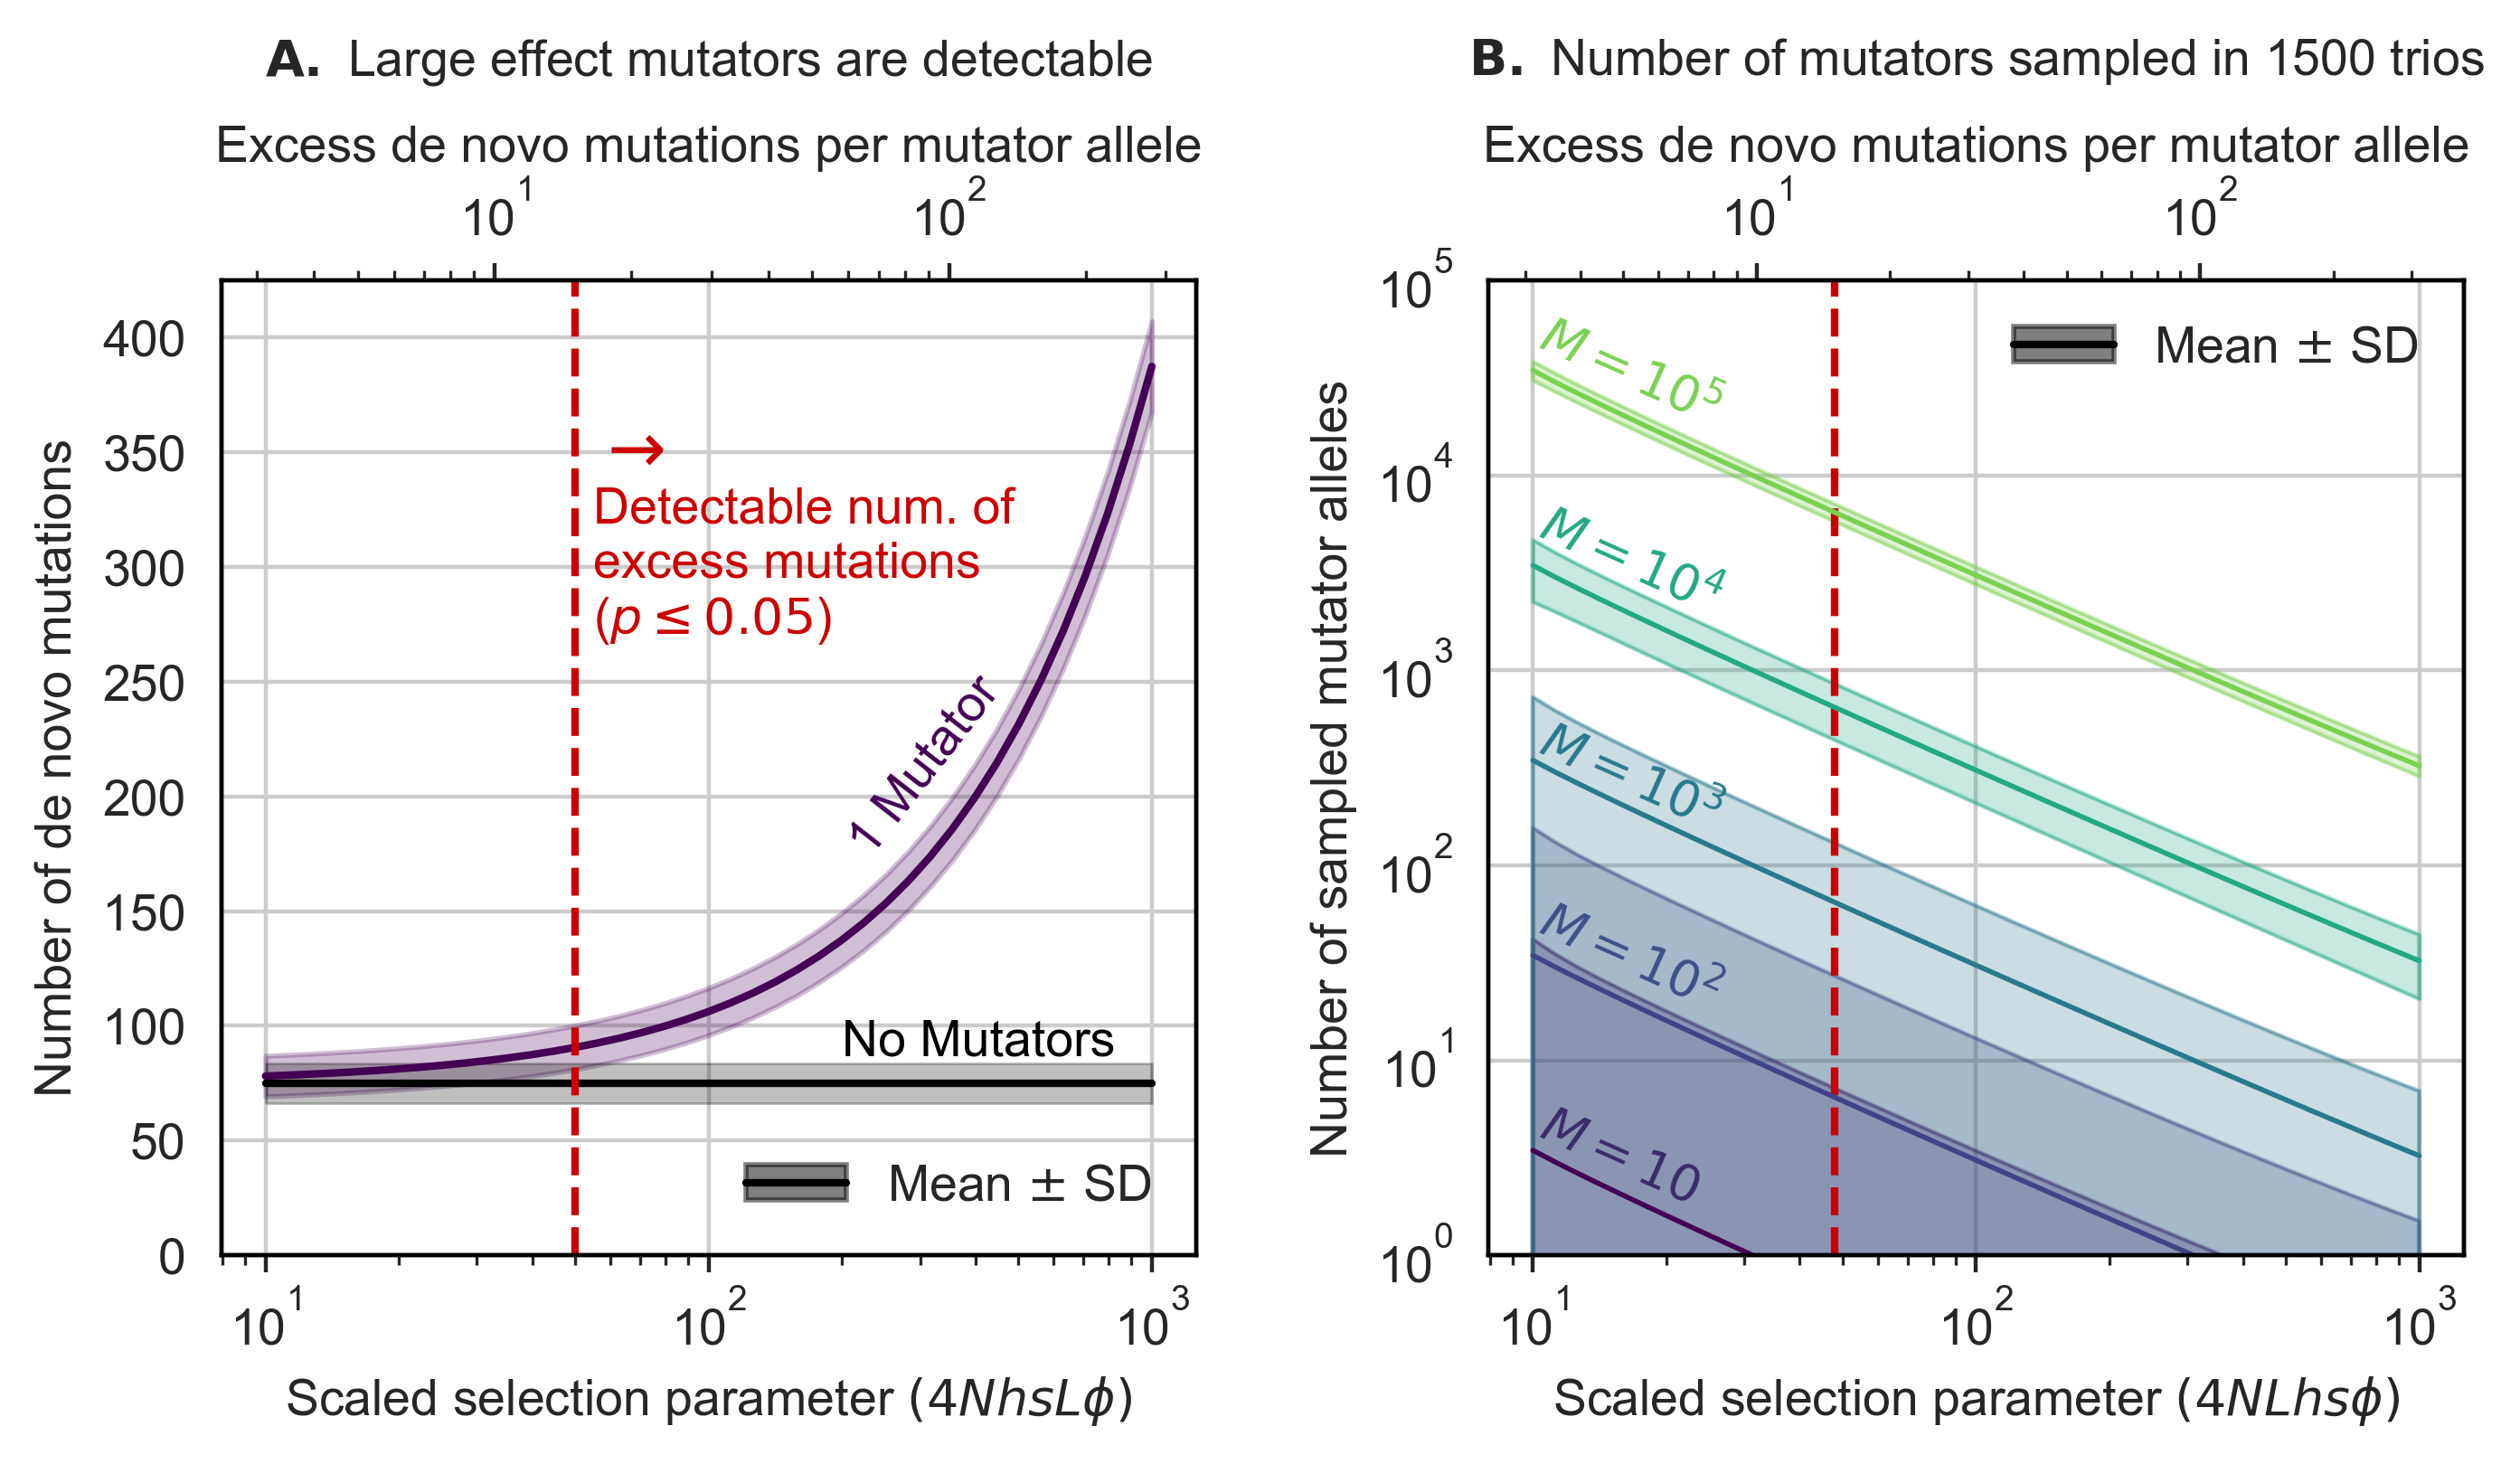

In [77]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (8,3.57),dpi=400)
make_mean_figure(ax2)
detection_figure(ax1)
plt.subplots_adjust(wspace=0.3)
bbox = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height
print(round(width/height,3))
plt.savefig('/Users/will_milligan/Desktop/MutatorFigures/Fig6.pdf',dpi=400,bbox_inches='tight')

Text(16, 0.22, '$\\rightarrow$')

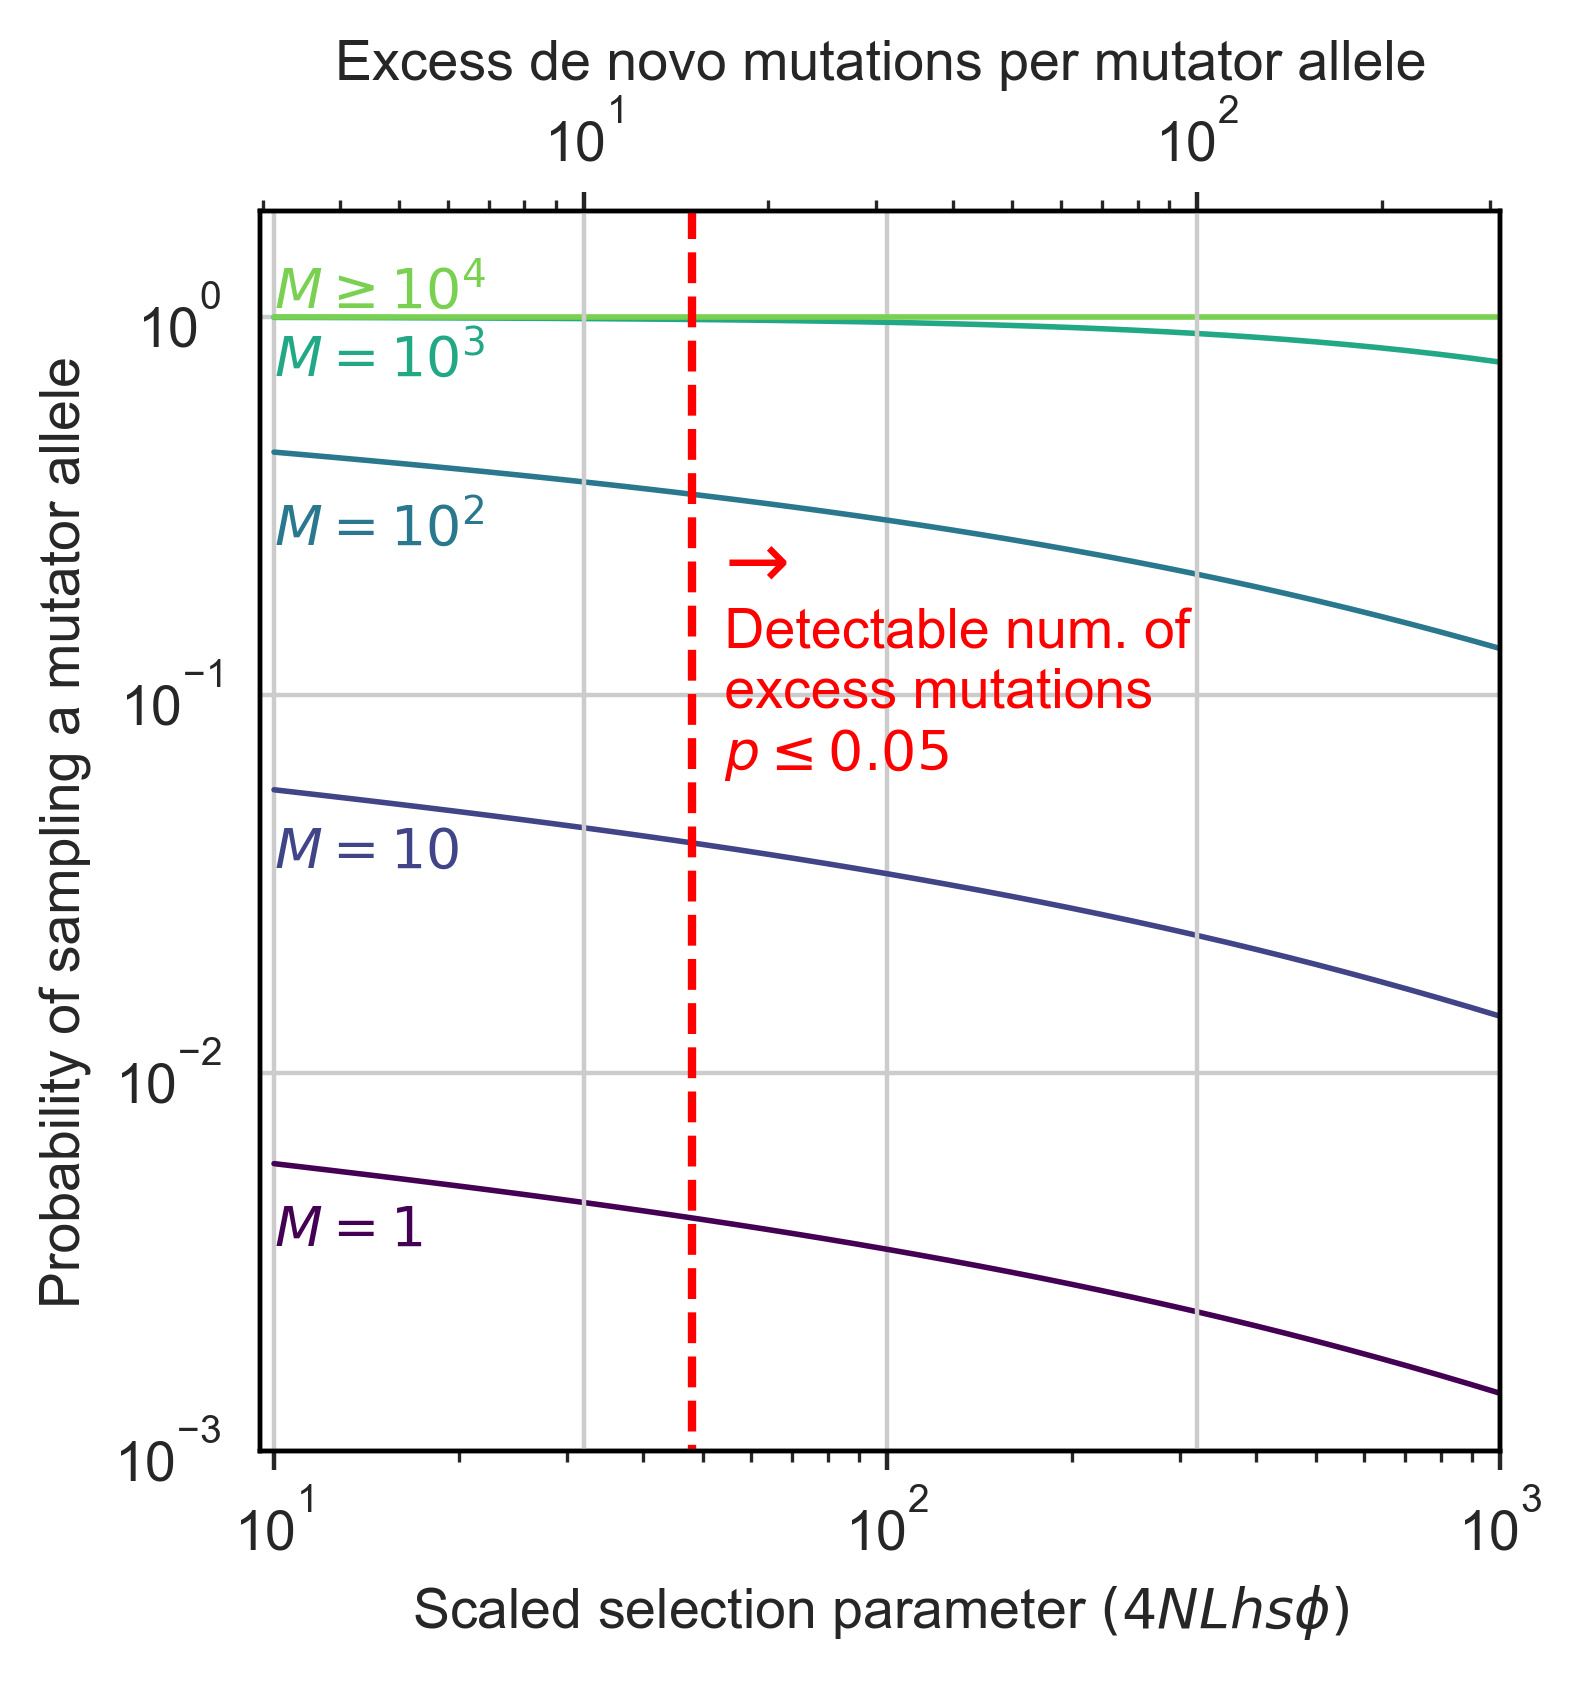

In [59]:
# for plotting legend entries
def get_M_label(M):
    if M >= 1e4:
        s = r'$M \geq 10^4$'
        y = 1.06
    elif M == 1e3:
        y = 0.7
        s = r'$M = 10^3$'
    elif M == 1e2:
        y = 0.25
        s = r'$M = 10^2$'
    elif M == 1e1:
        y = 0.035
        s = r'$M = 10$'
    elif M == 1e0:
        y = 0.0035
        s = r'$M = 1$'
    else:
        print('A PROBLEM',M)
        
    return s,y
        
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4.105),dpi=400)
plt.sca(ax)

# plot probability of sampling at least one mutators
colors = [mpl.cm.get_cmap('viridis')(i) for i in np.linspace(0,4/5,5)]
for M,color in zip(np.logspace(0,4,5),colors):
    plt.plot(s_values,1-prob_zero_mutators**M,color=color,ls='-',linewidth=1)
    M_label_s,M_label_y = get_M_label(M)
    plt.text(x = 10,y = M_label_y, s = M_label_s,color=color,rotation = 0,size = 10)

# adjust plt axes
plt.subplots_adjust(wspace=0,hspace=0.3)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Probability of sampling a mutator allele')
plt.xlabel(r'Scaled selection parameter $\left(4NLhs\phi\right)$')
plt.ylim([1e-3,1.9])
plt.xlim([min(s_values)*0.95,max(s_values)])
plt.xlim([9.5,max(s_values)])

# do all things related to second x - axis
ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.plot(get_phi(s_values)*3e9,1-prob_zero_mutators**M,color=[0,0,0,0])
ax2.set_xlim([min_phi*0.95*3e9,max(phi_values)*3e9])
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('Excess de novo mutations per mutator allele')

for ax in [ax1,ax2]:
    for spine in ax.spines.values():
        spine.set_color('k')
        
# designated significance threshold
FDR = 0.05
vline_color = 'r'
v_line_value = stats.poisson.ppf(1-FDR,mu=1.25e-8*3e9*2)-1.25e-8*3e9*2
ax2.vlines([stats.poisson.ppf(1-FDR,mu=1.25e-8*3e9*2)-1.25e-8*3e9*2],ymin=1e-4,ymax=2,color=vline_color,ls='--')
ax2.text(x = 16, y = 0.1,s = ' Detectable num. of\n excess mutations\n $p \leq 0.05$',size = 10,color=vline_color,va= 'center')
ax2.text(x = 16, y = 0.22,s = r'$\rightarrow$',size = 14,color=vline_color,va= 'center')